In [ ]:
%%time
%config Completer.use_jedi = False
#!/usr/bin/env python3
import wmfdata
import pandas as pd
import numpy as np
from sklearn.metrics import auc
import matplotlib.pyplot as plt
from IPython.core.display import HTML

In [2]:
%%time
outputHDFS = 'riskobservatory'
!hadoop fs -mkdir $outputHDFS

mkdir: `riskobservatory': File exists
CPU times: user 54.3 ms, sys: 39.7 ms, total: 94 ms
Wall time: 2.17 s


In [3]:
%%time
spark = wmfdata.spark.get_session(
    app_name='self reverts',
    type='yarn-regular'
)
import pyspark.sql.functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import desc
from pyspark.sql.functions import col

PySpark executors will use /usr/lib/anaconda-wmf/bin/python3.


CPU times: user 338 ms, sys: 64.7 ms, total: 403 ms
Wall time: 12.1 s


In [4]:
%%time
df = spark.read.parquet('/user/paragon/riskobservatory/revertrisk_2022')
df_reverts = df.filter(df.revision_is_identity_reverted)

CPU times: user 7.97 ms, sys: 0 ns, total: 7.97 ms
Wall time: 7.27 s


In [5]:
%%time
df_reverts.show()

+---------+-------+--------------------+-----------------------------+-----------------------------------+--------+--------------------+
|   rev_id|wiki_db|       rev_timestamp|revision_is_identity_reverted|revision_seconds_to_identity_revert| page_id|revision_revert_risk|
+---------+-------+--------------------+-----------------------------+-----------------------------------+--------+--------------------+
| 24351456| srwiki|2022-02-02T13:36:...|                         true|                               5669|   21447|           0.9756566|
|141763475| eswiki|2022-02-18T15:16:...|                         true|                               4086| 1002363|           0.9020463|
|142996096| eswiki|2022-04-19T13:32:...|                         true|                                 20| 4504609|          0.84279275|
| 72507744| zhwiki|2022-07-04T20:40:...|                         true|                                140| 7696126|           0.6469931|
|219850446| dewiki|2022-02-04T07:58:...| 

In [6]:
%%time
df_reverts.createOrReplaceTempView('reverts_scores_table_wiki')

CPU times: user 1.34 ms, sys: 2.05 ms, total: 3.39 ms
Wall time: 188 ms


In [7]:
%%time
import pyspark.sql.functions as f
partitions = spark.sql('SHOW partitions wmf.mediawiki_history') \
        .withColumn("index", f.monotonically_increasing_id()) \
        .orderBy(f.desc("index")).drop("index")
partitions.show(20,False)
last_partition_mediawiki_history = partitions.head(n=10)[0]['partition'].split('=')[1].split('/')[0]
last_partition_mediawiki_history

+----------------+
|partition       |
+----------------+
|snapshot=2023-02|
|snapshot=2023-01|
|snapshot=2022-12|
|snapshot=2022-11|
|snapshot=2022-10|
|snapshot=2022-09|
+----------------+

CPU times: user 18.5 ms, sys: 6.92 ms, total: 25.4 ms
Wall time: 3.09 s


'2023-02'

In [8]:
%%time
df_reverts_metadata = spark.sql("""
WITH
all_revisions AS
      (SELECT wiki_db,
              revision_id rev_id,
              event_user_text user,
              event_user_is_anonymous user_is_anonymous,
              CARDINALITY(event_user_is_bot_by_historical)>0 user_is_bot,
              revision_first_identity_reverting_revision_id rev_reverting_id
       FROM wmf.mediawiki_history
       WHERE snapshot='{snapshot}'
       AND event_entity = 'revision'
       AND page_namespace = 0
       AND NOT page_is_redirect), 
--
scored_reverts AS
      (SELECT r.*,
              ar.user,
              ar.user_is_anonymous,
              ar.user_is_bot,
              ar.rev_reverting_id
       FROM reverts_scores_table_wiki r
       LEFT JOIN all_revisions ar
       ON (r.wiki_db=ar.wiki_db AND r.rev_id=ar.rev_id))
--
SELECT sr.*,
       ar.USER reverting_user
FROM scored_reverts sr
LEFT JOIN all_revisions ar
ON (sr.wiki_db=ar.wiki_db AND sr.rev_reverting_id=ar.rev_id)
""".format(snapshot=last_partition_mediawiki_history)) \
    .withColumn('is_self_revert',col('user') == col('reverting_user'))

CPU times: user 3.33 ms, sys: 2.41 ms, total: 5.74 ms
Wall time: 392 ms


In [9]:
%%time
df_reverts_metadata.show()

+--------+-------+--------------------+-----------------------------+-----------------------------------+-------+--------------------+---------------+-----------------+-----------+----------------+--------------------+--------------+
|  rev_id|wiki_db|       rev_timestamp|revision_is_identity_reverted|revision_seconds_to_identity_revert|page_id|revision_revert_risk|           user|user_is_anonymous|user_is_bot|rev_reverting_id|      reverting_user|is_self_revert|
+--------+-------+--------------------+-----------------------------+-----------------------------------+-------+--------------------+---------------+-----------------+-----------+----------------+--------------------+--------------+
|  142737|acewiki|2022-09-23T14:20:...|                         true|                                  6|  15298|          0.86985546|   5.173.148.35|             true|      false|          142738|        Silencemen21|         false|
| 2491849| afwiki|2022-04-05T11:42:...|                         

In [10]:
%%time
df_reverts_metadata.write.parquet(outputHDFS+'/revertrisk_2022_reverts_metadata.parquet', mode='overwrite')

CPU times: user 78.5 ms, sys: 47.2 ms, total: 126 ms
Wall time: 10min 51s


In [11]:
%%time
df_reverts = spark.read.parquet(outputHDFS+'/revertrisk_2022_reverts_metadata.parquet')

CPU times: user 3.66 ms, sys: 1.54 ms, total: 5.2 ms
Wall time: 929 ms


In [12]:
%%time
df_reverts.show()

+--------+-------+--------------------+-----------------------------+-----------------------------------+-------+--------------------+---------------+-----------------+-----------+----------------+--------------+--------------+
|  rev_id|wiki_db|       rev_timestamp|revision_is_identity_reverted|revision_seconds_to_identity_revert|page_id|revision_revert_risk|           user|user_is_anonymous|user_is_bot|rev_reverting_id|reverting_user|is_self_revert|
+--------+-------+--------------------+-----------------------------+-----------------------------------+-------+--------------------+---------------+-----------------+-----------+----------------+--------------+--------------+
| 2491685| afwiki|2022-04-04T16:10:...|                         true|                                163|  52273|           0.8995892|Hyperbottle1999|            false|      false|         2491687|       Oesjaar|         false|
| 2491686| afwiki|2022-04-04T16:11:...|                         true|                   

In [13]:
%%time
df_reverts.groupby('is_self_revert').count().sort(desc('count')).show()

+--------------+-------+
|is_self_revert|  count|
+--------------+-------+
|         false|6133024|
|          true| 706266|
|          null|  17047|
+--------------+-------+

CPU times: user 4.92 ms, sys: 3.52 ms, total: 8.44 ms
Wall time: 1.62 s


In [14]:
df_reverts = df_reverts.filter(~df_reverts.is_self_revert.isNull())

In [15]:
%%time
wikis_count = df.filter(df.revision_revert_risk>=0).groupby('wiki_db').count().sort(desc('count'))
wikis_count.show()
wikis = wikis_count.select('wiki_db').toPandas().wiki_db.values
wikis

+-------+--------+
|wiki_db|   count|
+-------+--------+
| enwiki|29117575|
| frwiki| 4696006|
| eswiki| 4202298|
| dewiki| 4178692|
| ruwiki| 3782236|
| jawiki| 3326490|
| itwiki| 3266831|
| zhwiki| 2857798|
| arwiki| 1419547|
| kowiki| 1417395|
| plwiki| 1339167|
| hewiki| 1143733|
| idwiki| 1106010|
| cawiki| 1096876|
| nlwiki| 1090312|
| trwiki| 1049200|
| fawiki|  975311|
| cewiki|  933018|
| ptwiki|  833881|
| svwiki|  601051|
+-------+--------+
only showing top 20 rows

CPU times: user 33.6 ms, sys: 13.1 ms, total: 46.7 ms
Wall time: 19.1 s


array(['enwiki', 'frwiki', 'eswiki', 'dewiki', 'ruwiki', 'jawiki',
       'itwiki', 'zhwiki', 'arwiki', 'kowiki', 'plwiki', 'hewiki',
       'idwiki', 'cawiki', 'nlwiki', 'trwiki', 'fawiki', 'cewiki',
       'ptwiki', 'svwiki', 'cswiki', 'srwiki', 'huwiki', 'nowiki',
       'cywiki', 'thwiki', 'arzwiki', 'uzwiki', 'bnwiki', 'elwiki',
       'simplewiki', 'rowiki', 'azwiki', 'cebwiki', 'minwiki', 'ttwiki',
       'bgwiki', 'ltwiki', 'urwiki', 'mswiki', 'eowiki', 'dawiki',
       'hywiki', 'tewiki', 'glwiki', 'hrwiki', 'euwiki', 'bewiki',
       'tawiki', 'astwiki', 'mrwiki', 'etwiki', 'slwiki', 'lvwiki',
       'kawiki', 'sqwiki', 'brwiki', 'ckbwiki', 'bawiki', 'gawiki',
       'mlwiki', 'hawiki', 'nnwiki', 'kuwiki', 'afwiki', 'tlwiki',
       'arywiki', 'bswiki', 'lawiki', 'avkwiki', 'anwiki', 'lmowiki',
       'knwiki', 'shwiki', 'fywiki', 'nahwiki', 'iswiki', 'ocwiki',
       'lbwiki', 'mywiki', 'igwiki', 'orwiki', 'pawiki', 'mnwiki',
       'xmfwiki', 'tgwiki', 'aswiki', 'lldwiki', 

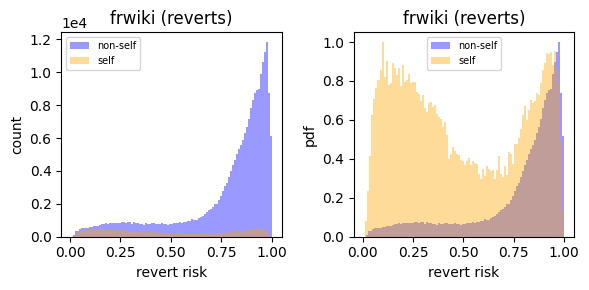

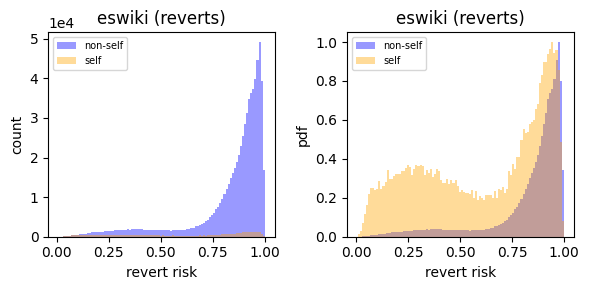

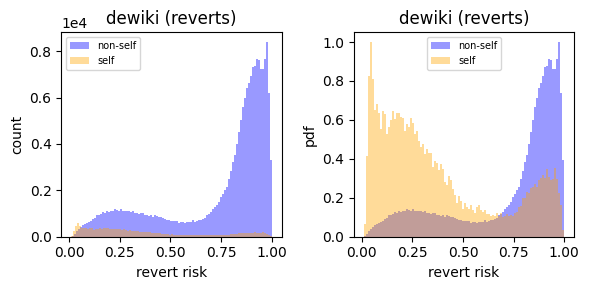

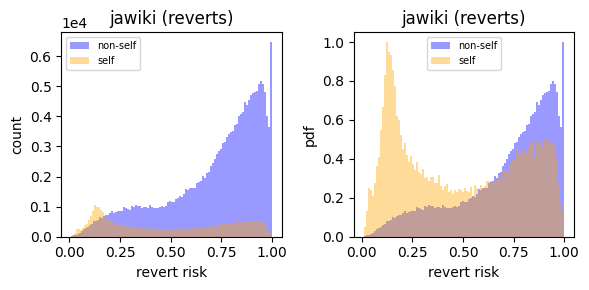

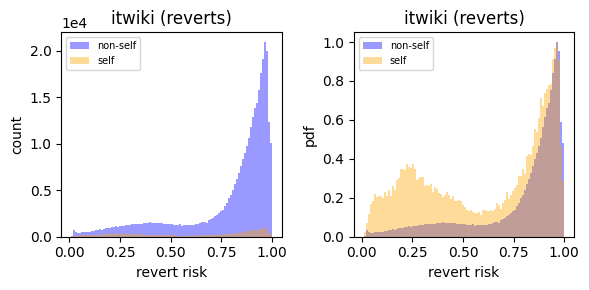

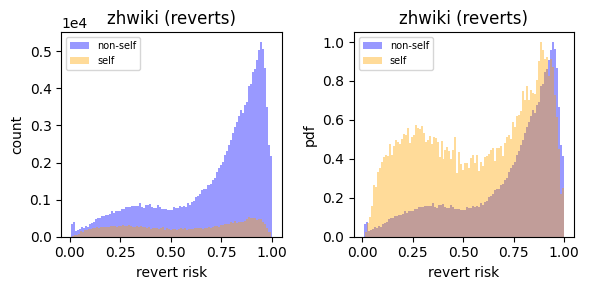

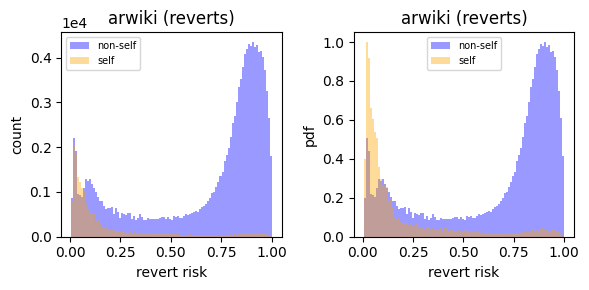

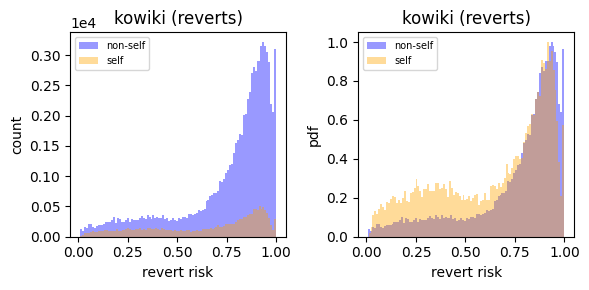

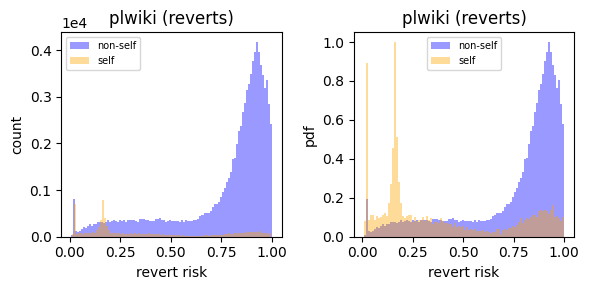

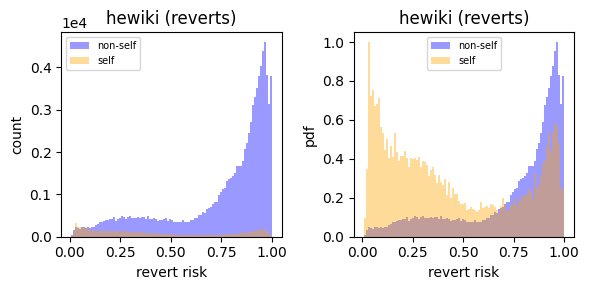

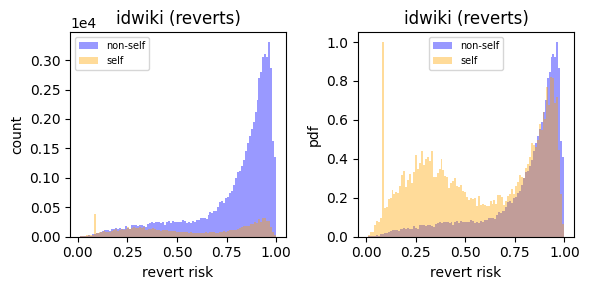

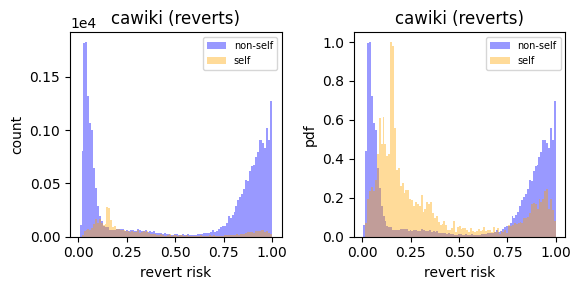

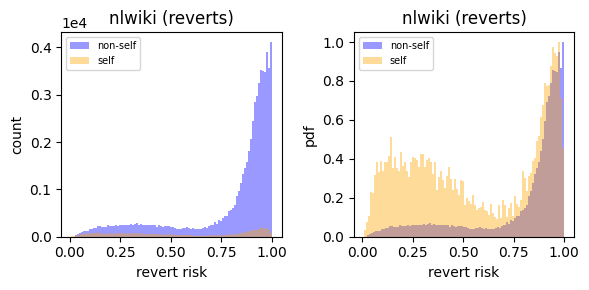

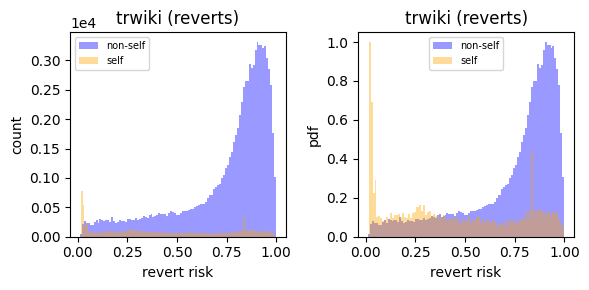

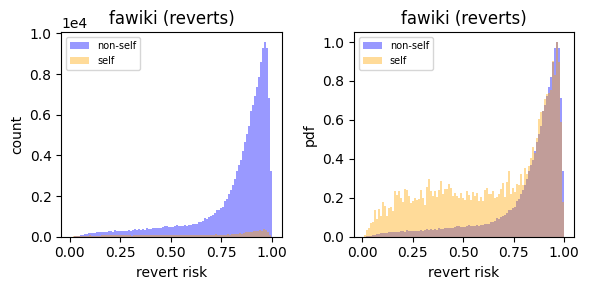

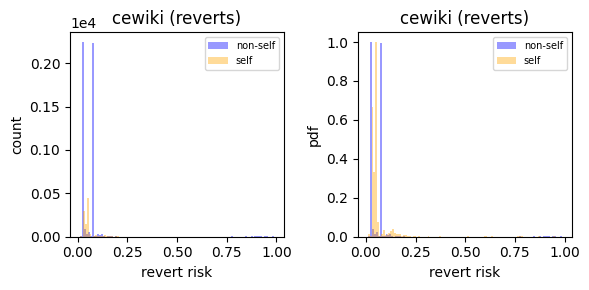

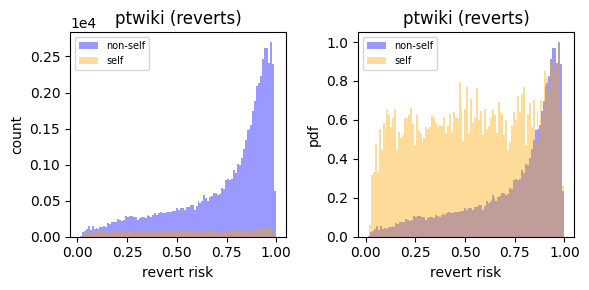

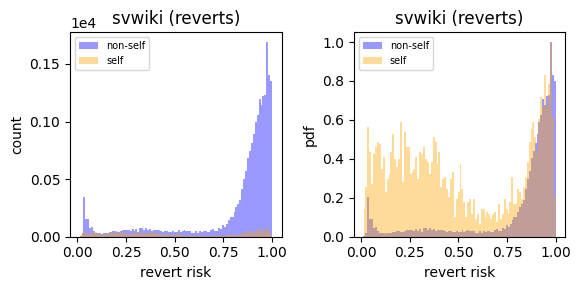

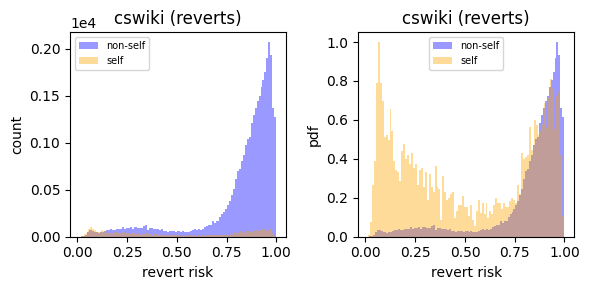

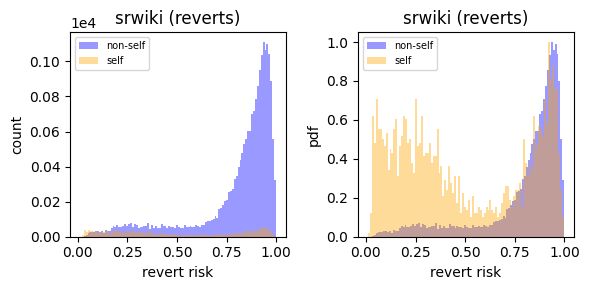

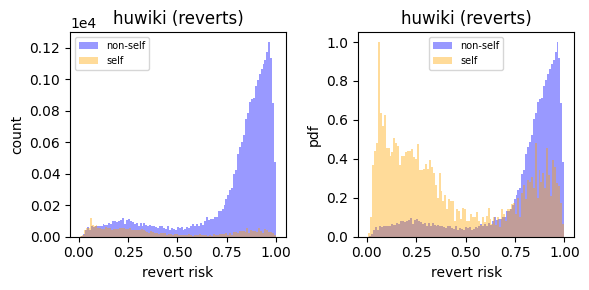

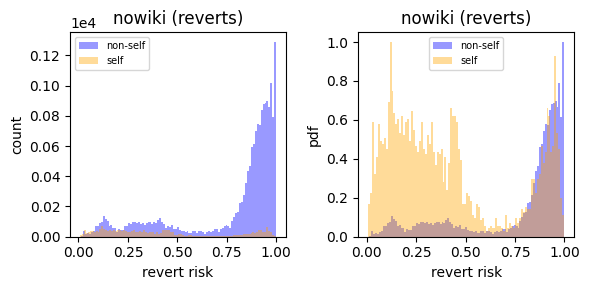

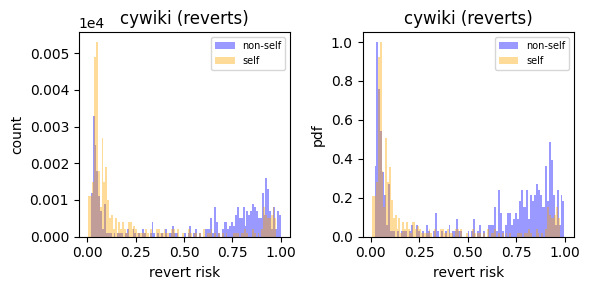

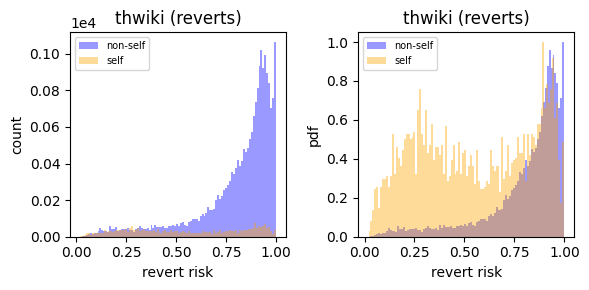

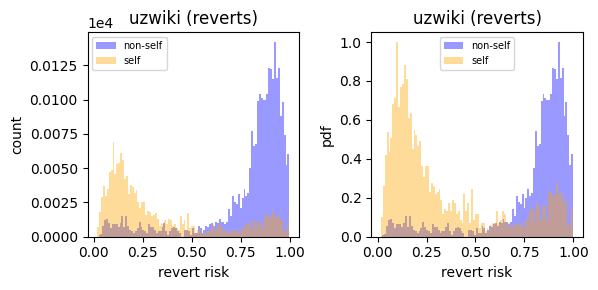

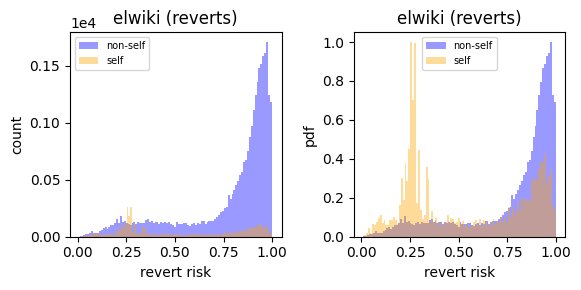

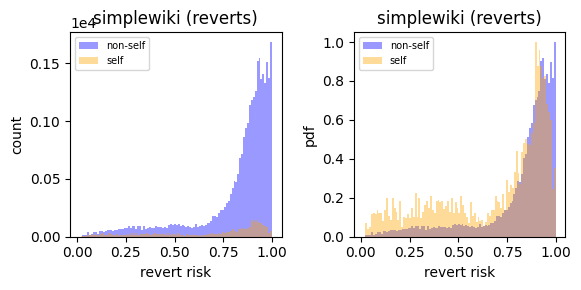

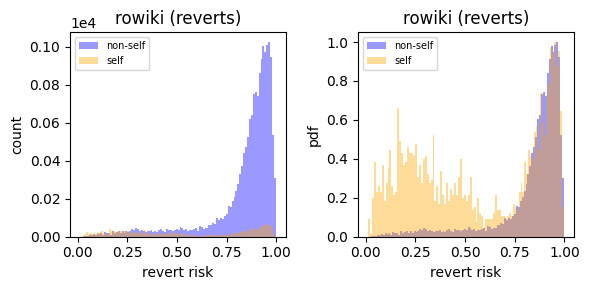

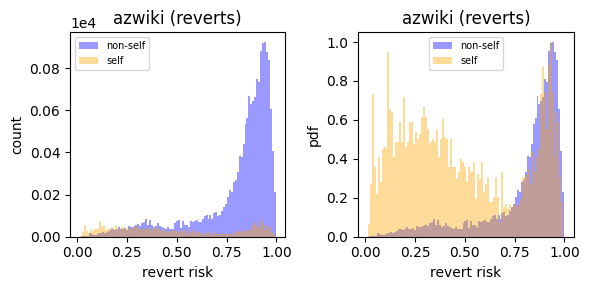

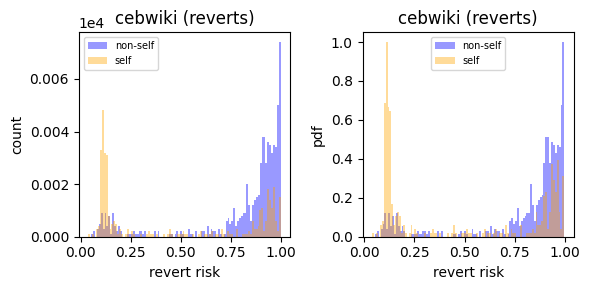

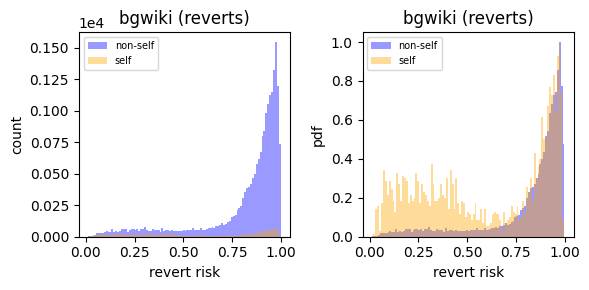

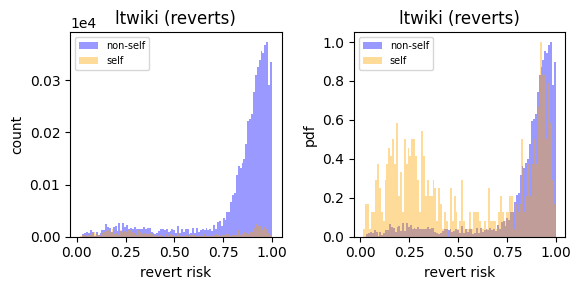

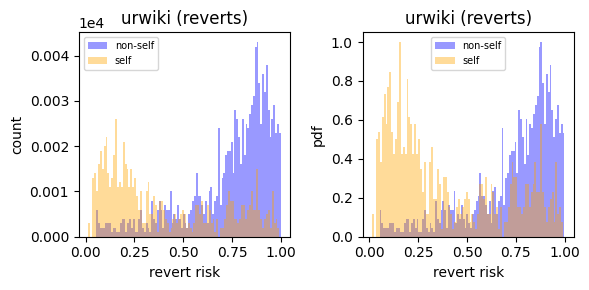

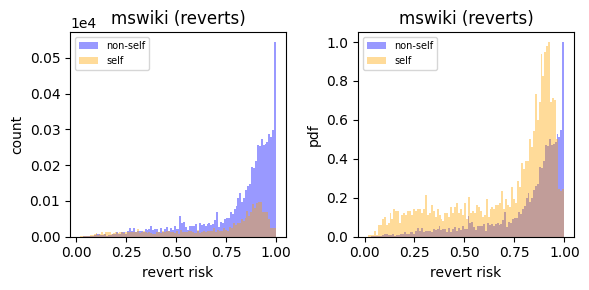

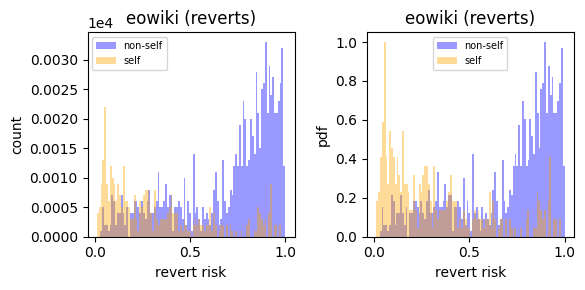

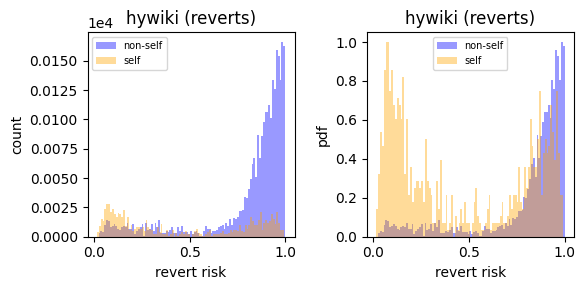

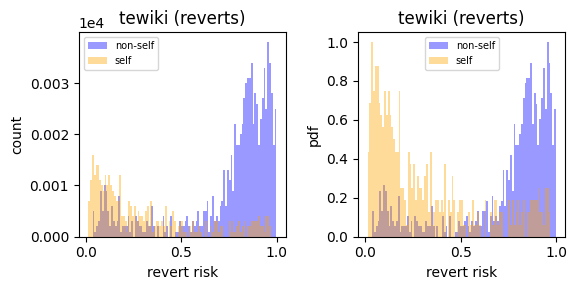

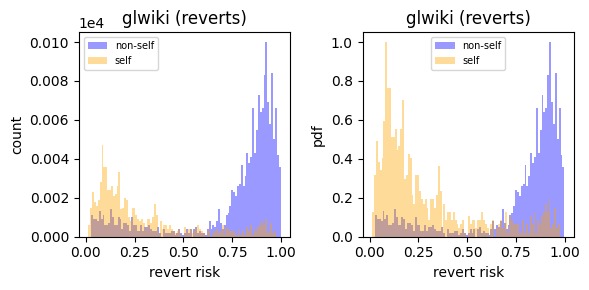

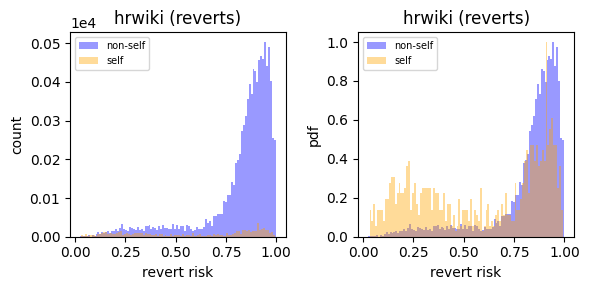

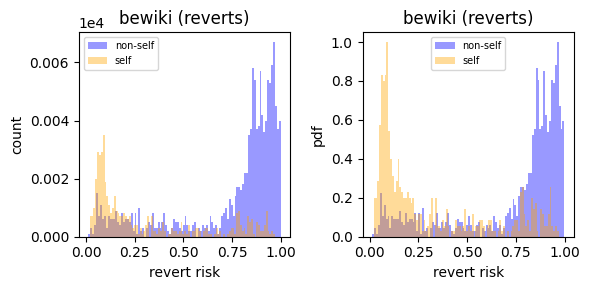

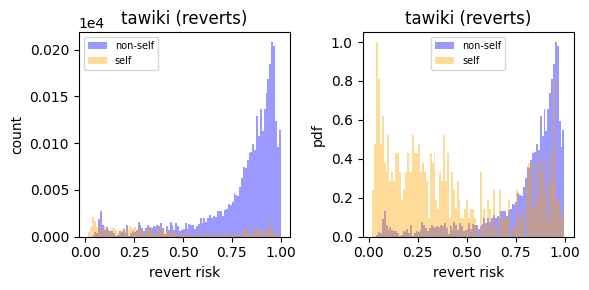

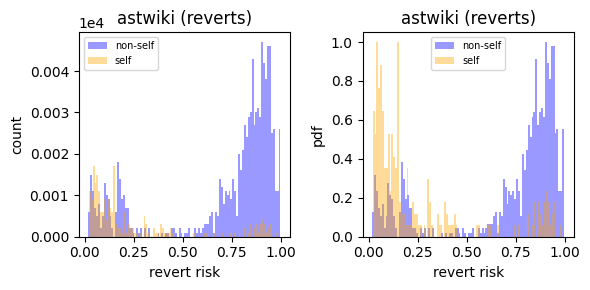

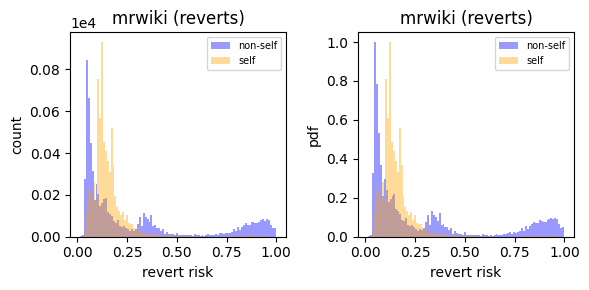

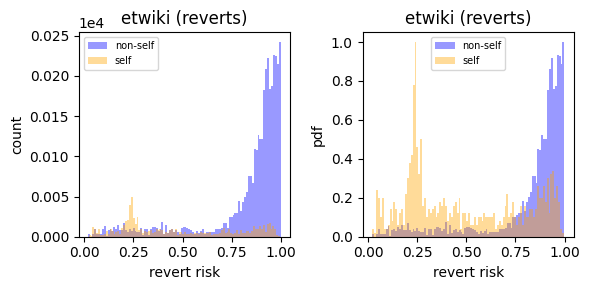

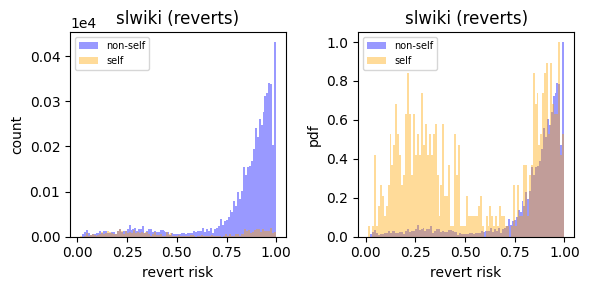

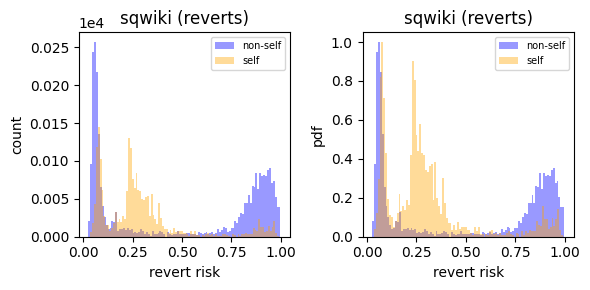

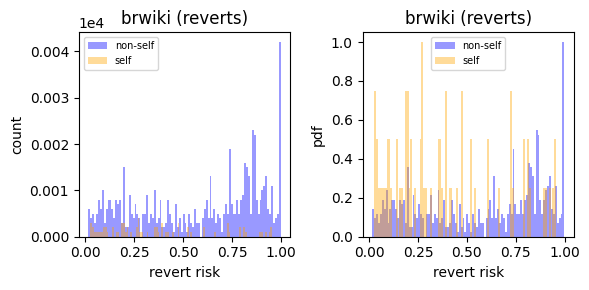

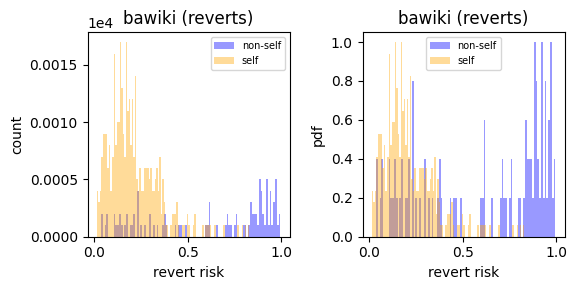

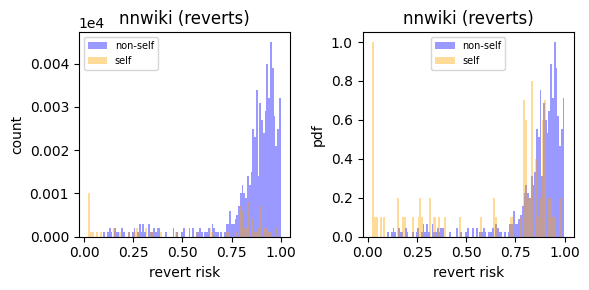

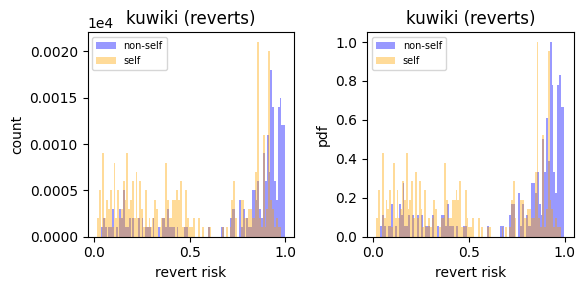

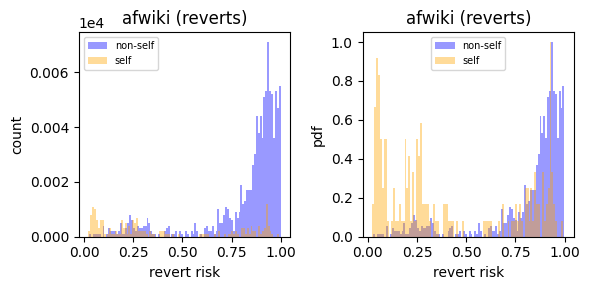

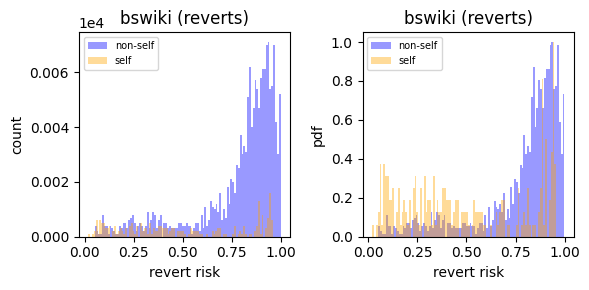

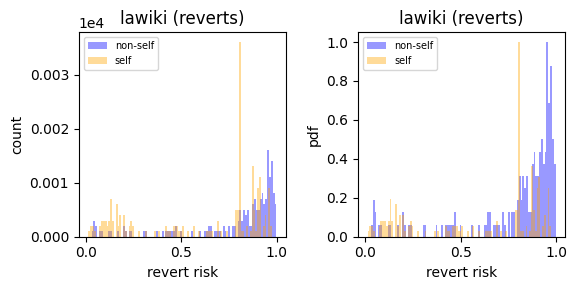

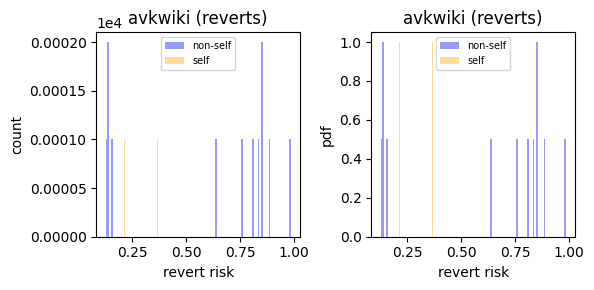

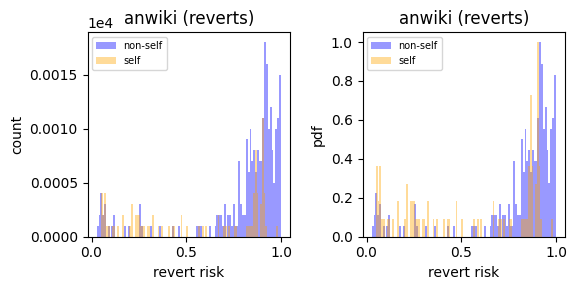

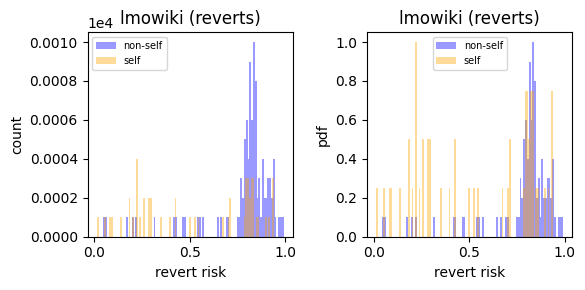

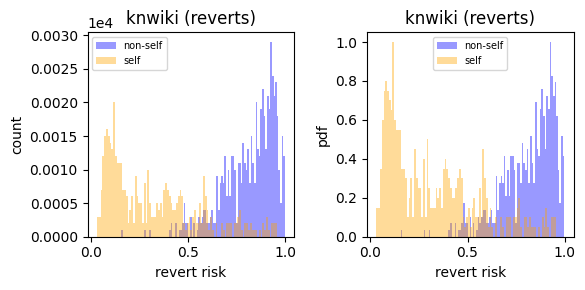

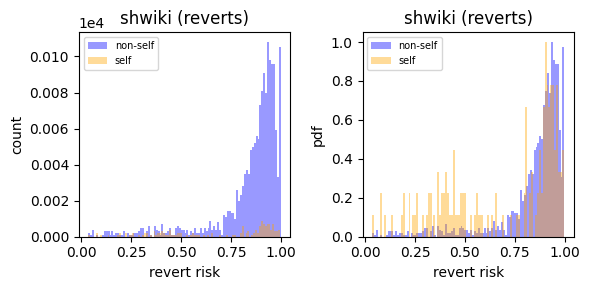

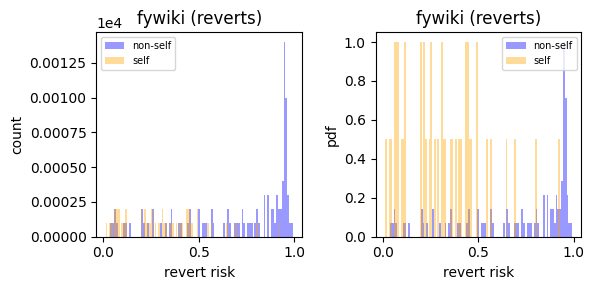

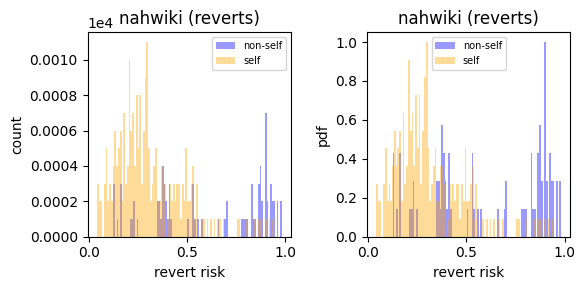

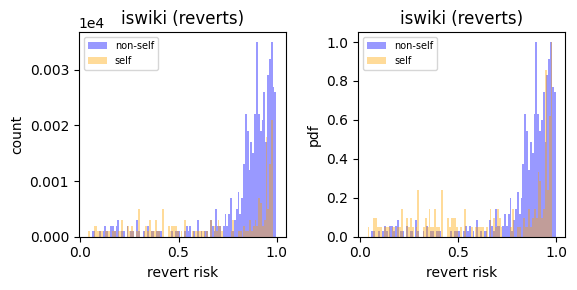

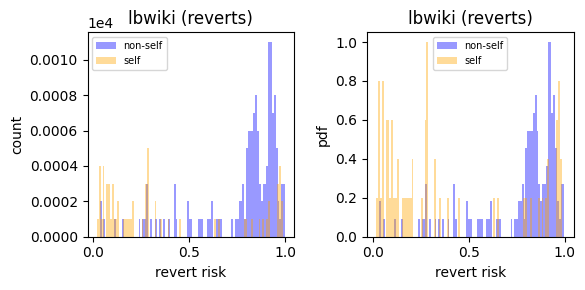

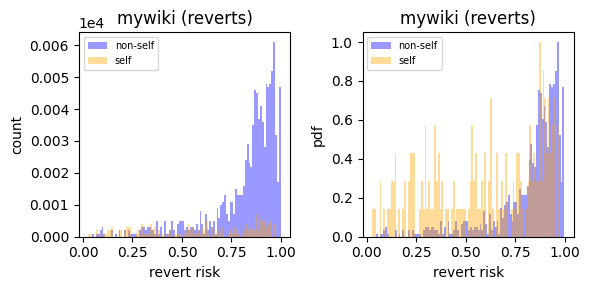

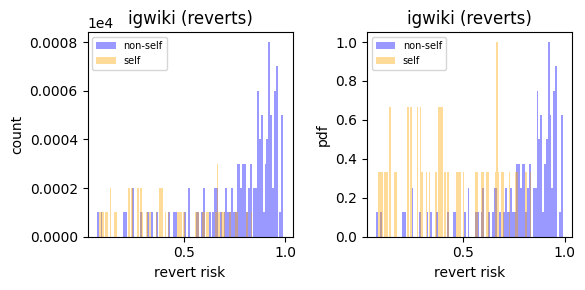

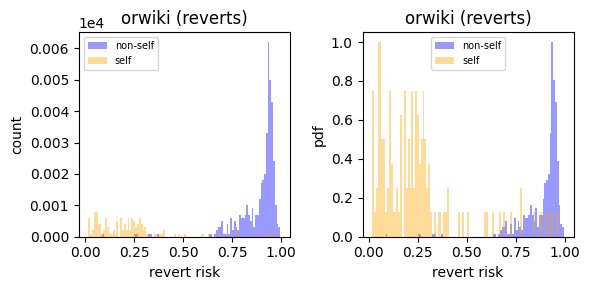

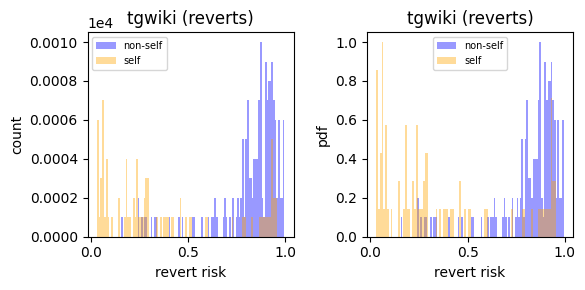

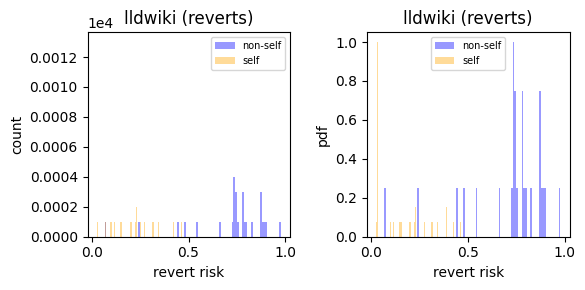

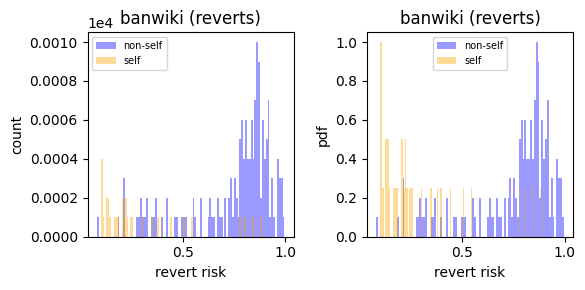

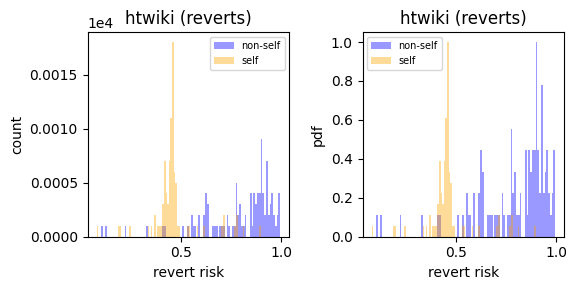

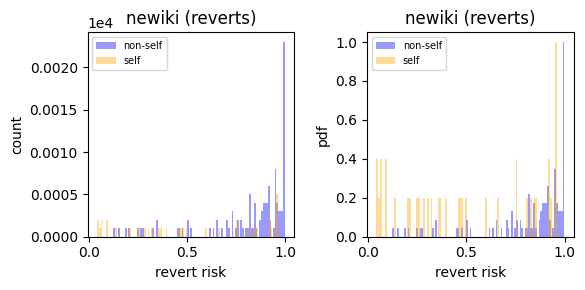

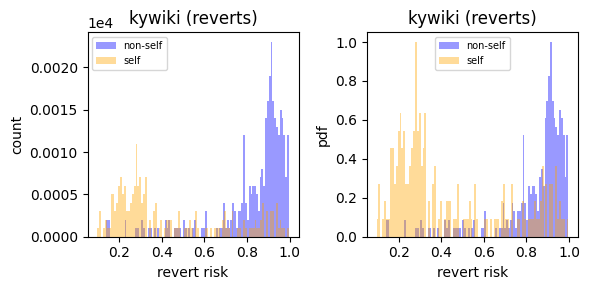

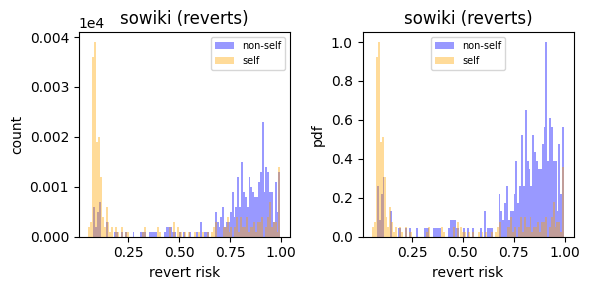

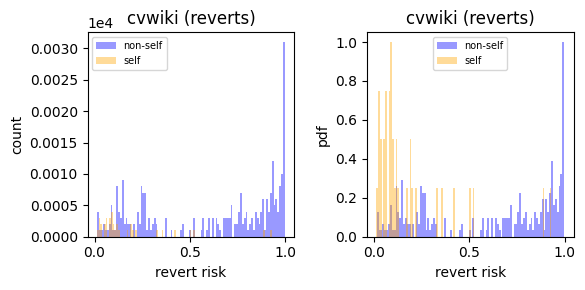

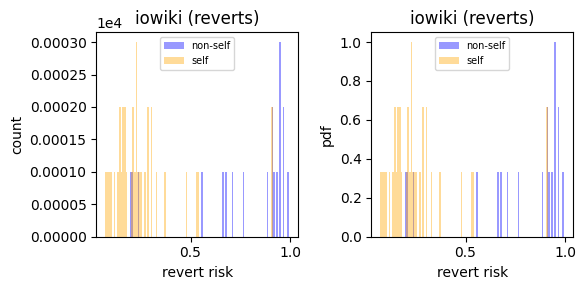

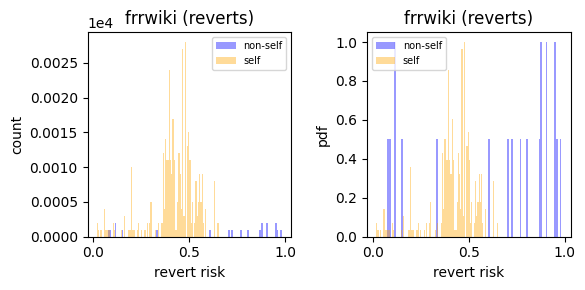

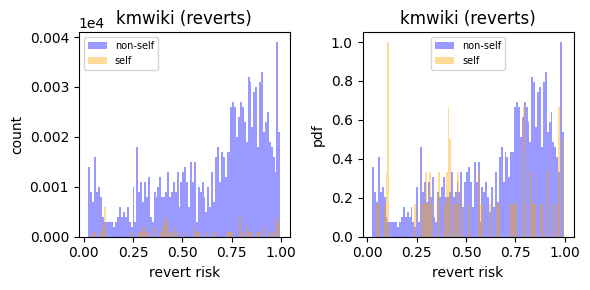

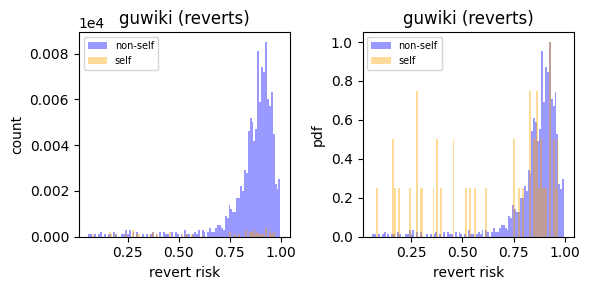

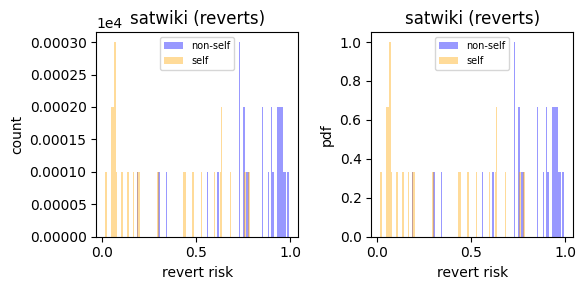

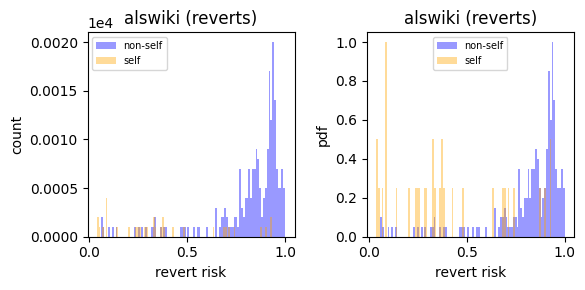

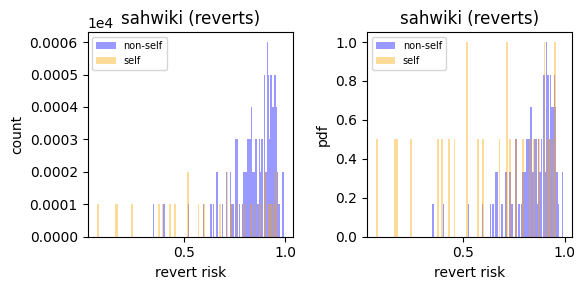

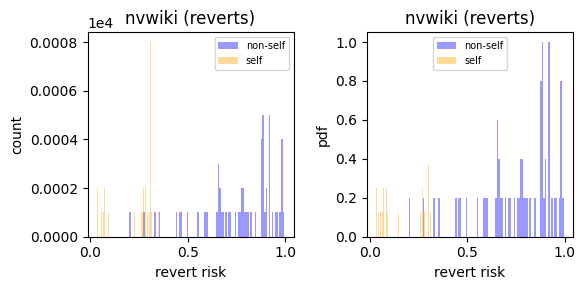

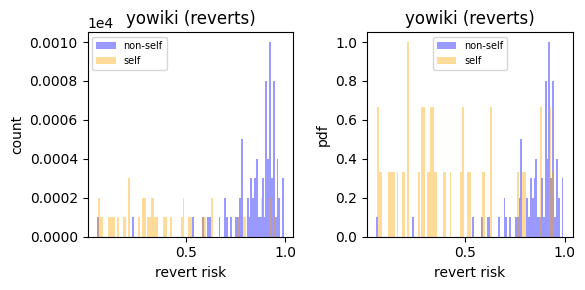

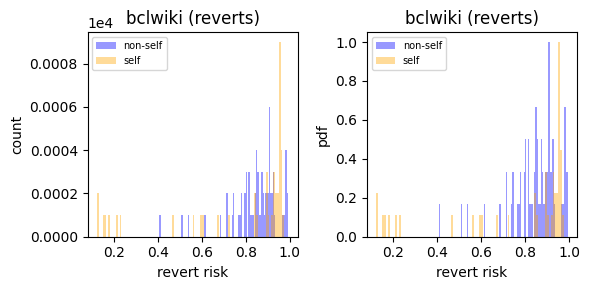

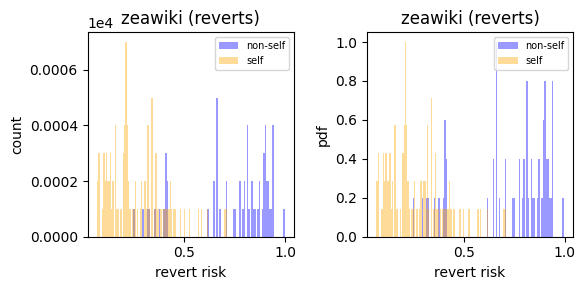

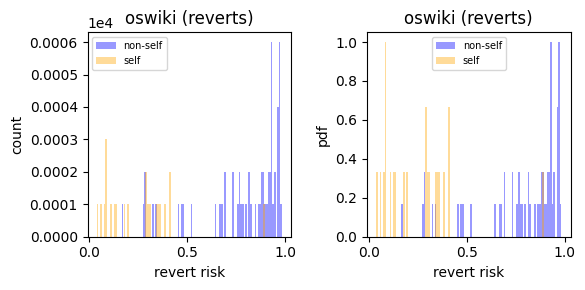

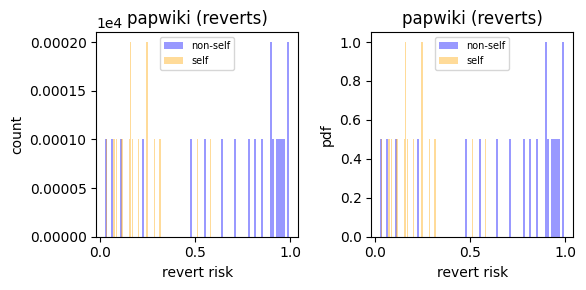

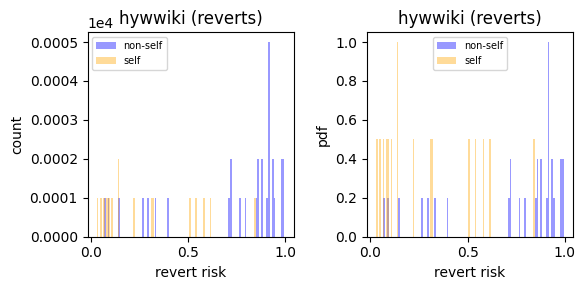

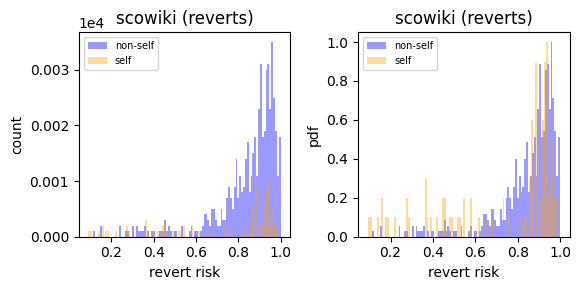

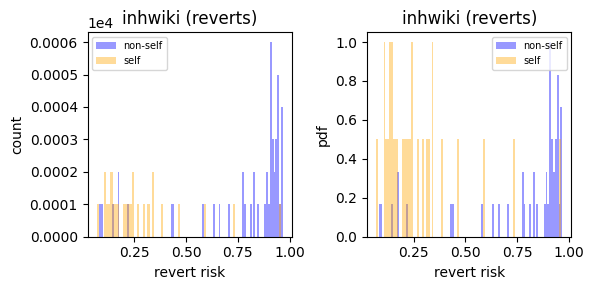

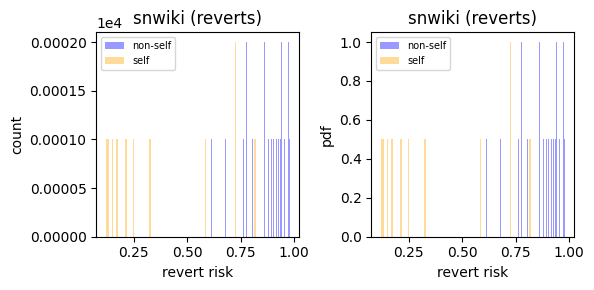

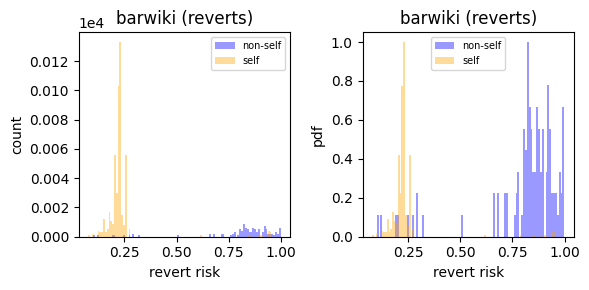

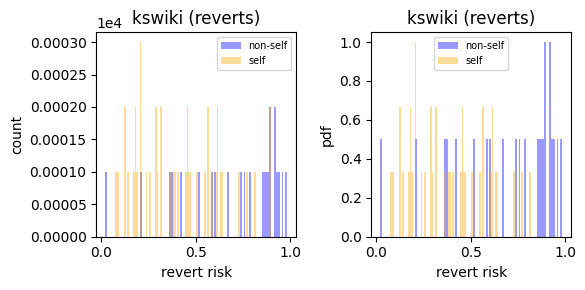

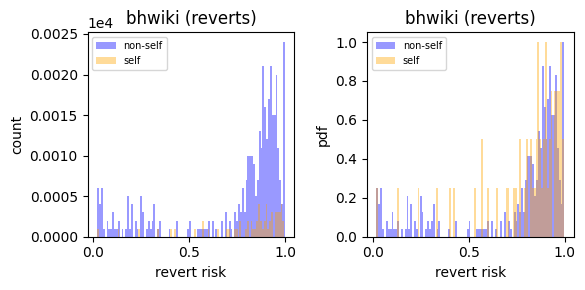

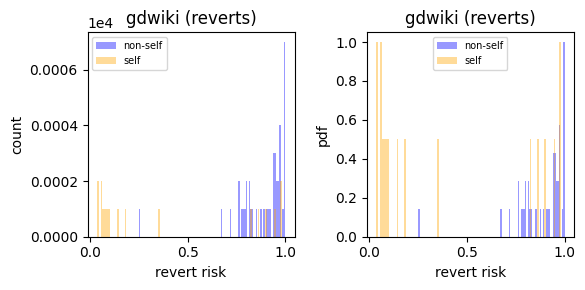

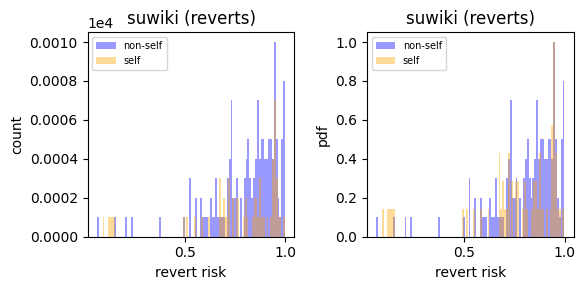

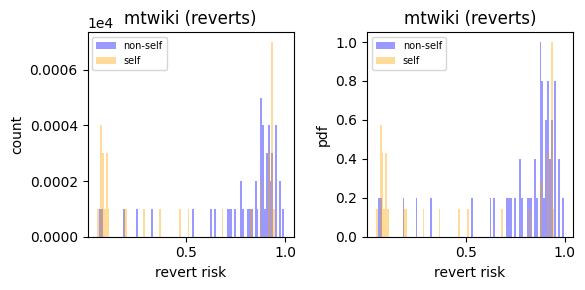

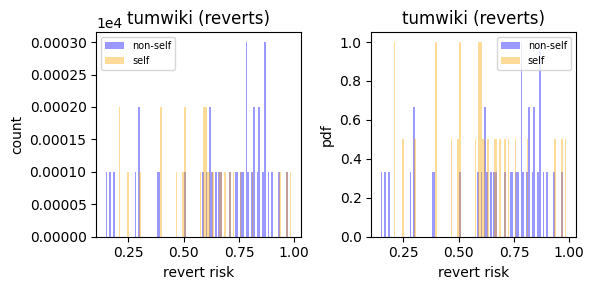

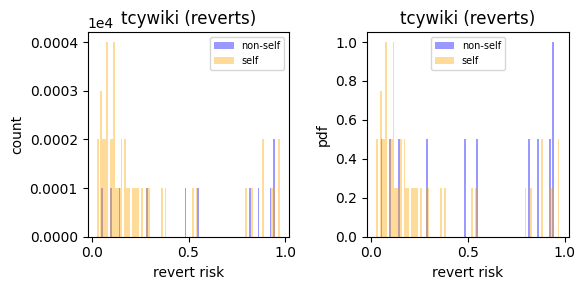

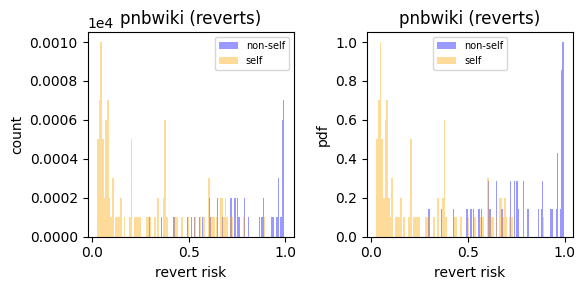

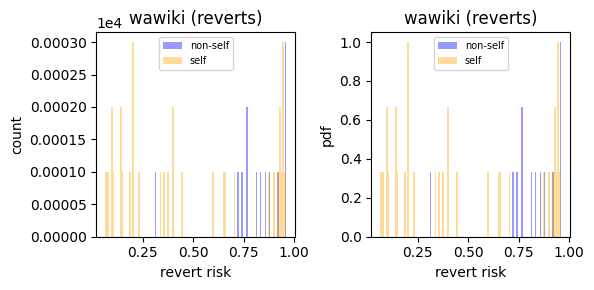

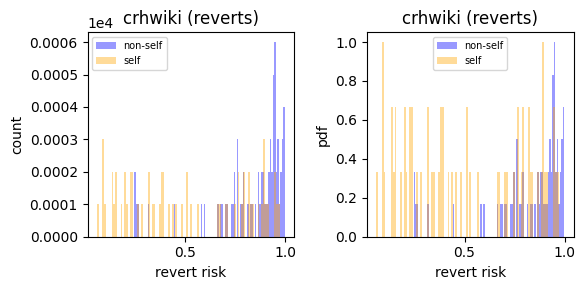

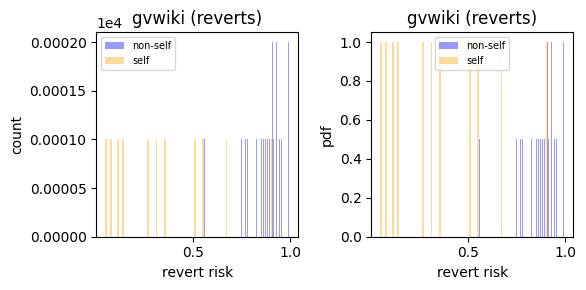

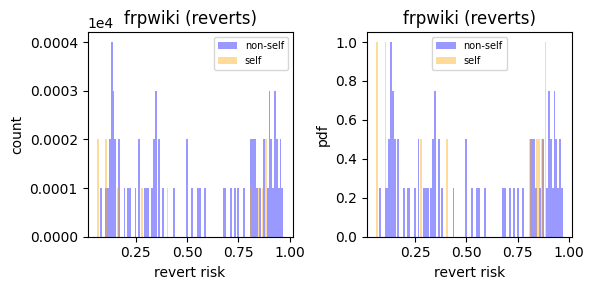

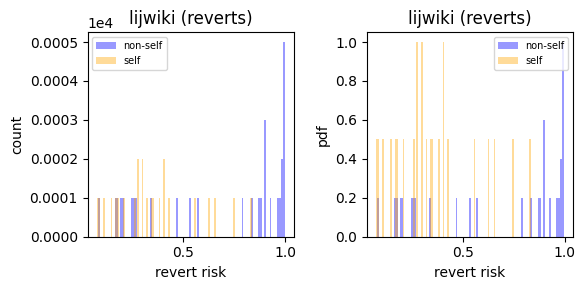

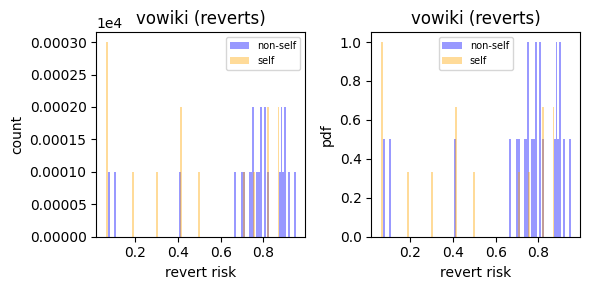

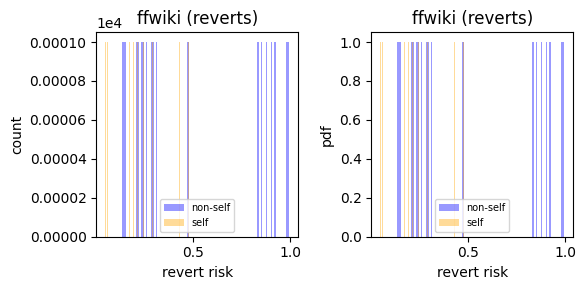

ValueError: Can not reduce() empty RDD

In [16]:
%%time
for wiki_db in wikis[:]:
    display(HTML('<h1>'+wiki_db+'</h1>'))
    bins_non_self_reverts, counts_non_self_reverts = df_reverts.filter((df_reverts.wiki_db == wiki_db)&(~df_reverts.is_self_revert)) \
                            .select('revision_revert_risk').rdd.flatMap(lambda x: x).histogram(100)
    bins_self_reverts, counts_self_reverts = df_reverts.filter((df_reverts.wiki_db == wiki_db)&(df_reverts.is_self_revert)) \
                            .select('revision_revert_risk').rdd.flatMap(lambda x: x).histogram(100)    
    #######################
    fig, ax = plt.subplots(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.hist(bins_non_self_reverts[:-1], bins=bins_non_self_reverts, weights=counts_non_self_reverts, color='blue', alpha=0.4, label='non-self')
    plt.hist(bins_self_reverts[:-1], bins=bins_self_reverts, weights=counts_self_reverts, color='orange', alpha=0.4, label='self')
    plt.ylabel('count')
    plt.ticklabel_format(axis='y', style='sci', scilimits=(4,4))
    plt.xlabel('revert risk')
    plt.legend(fontsize=7)
    plt.title(wiki_db+' (reverts)')
    #######################
    plt.subplot(1, 2, 2)
    plt.hist(bins_non_self_reverts[:-1], bins=bins_non_self_reverts, weights=np.array(counts_non_self_reverts)/max(counts_non_self_reverts), color='blue', alpha=0.4, label='non-self')
    plt.hist(bins_self_reverts[:-1], bins=bins_self_reverts, weights=np.array(counts_self_reverts)/max(counts_self_reverts), color='orange', alpha=0.4, label='self')
    plt.ylabel('pdf')
    plt.xlabel('revert risk')    
    plt.legend(fontsize=7)
    plt.title(wiki_db+' (reverts)')
    #######################
    plt.tight_layout()
    plt.savefig('../figures/{wiki_db}_self.pdf'.format(wiki_db=wiki_db), format="pdf", bbox_inches="tight")
    plt.savefig('../figures/{wiki_db}_self.png'.format(wiki_db=wiki_db), format="png", bbox_inches="tight")
    plt.show()